# setup

In [1]:
%%capture
!pip install seaborn

!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install beartype
!pip install pysteps
!pip install w

In [1]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [2]:
from pysteps.utils.spectral import rapsd, corrcoef
from scipy.stats import wasserstein_distance

# +
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy


from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from functools import partial
from abc import abstractmethod
from skimage.transform import rescale


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, SR_BC_GFDL_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [3]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from tqdm import tqdm
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker

import tqdm
#from src.psd_utils import SpatialSpectralDensity_4_diff_res, SpatialSpectralDensity_diff_res

from src.utils import *
from src.helper import *
from src.utils_essential import *


from src.base_network import BaseNetwork



from src.imagen_unet import *
# -

from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

config = {"run_name": "bc_sr_imagen_dn1000",     
          "epochs":        400,
          "batch_size":    4, 
          "lr":            1e-5, 
          "image_size":    256,             
          "device":        "cuda", 
          "num_workers":   8, 
}
#wandb.config.update({"batch_size": 32})

wandb.init(project='climate-diffusion', entity='Michi',config=config, save_code=True)

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

# # Dataloaders 

# +
era5_hr_ds = era5_0_25d_256(stage='train')


era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=wandb.config.batch_size, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)

sample_era5_025_tr = next(iter(era5_hr_dl))
print("HR ERA5", sample_era5_025_tr.shape)

# +
era5_lr_ds = era5_upscaled_1d_256(stage='train')

era5_lr_dl = data.DataLoader(era5_lr_ds, batch_size=wandb.config.batch_size, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)

sample_era5_1d_256p = next(iter(era5_lr_dl))
print("LR ERA5", sample_era5_1d_256p.shape)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


HR ERA5 torch.Size([4, 1, 256, 256])
LR ERA5 torch.Size([4, 1, 256, 256])


# Define model

In [4]:
def first(arr, d = None):
    if len(arr) == 0:
        return d
    return arr[0]

def resize_image_to(
    image,
    target_image_size,
    clamp_range = None,
    mode = 'nearest'):
    orig_image_size = image.shape[-1]

    if orig_image_size == target_image_size:
        return image

    out = F.interpolate(image, target_image_size, mode = mode)

    if exists(clamp_range):
        out = out.clamp(*clamp_range)

    return out

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

def module_device(module):
    return next(module.parameters()).device

def cast_uint8_images_to_float(images):
    if not images.dtype == torch.uint8:
        return images
    return images / 255


# -

# # Diffusion

class GaussianDiffusionContinuousTimes(BaseNetwork):
    def __init__(self, *, noise_schedule, timesteps = 1000,**kwargs):
        super(GaussianDiffusionContinuousTimes, self).__init__(**kwargs)
        
        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.num_timesteps = timesteps

    def get_times(self, batch_size, noise_level, *, device):
        return torch.full((batch_size,), noise_level, device = device, dtype = torch.float32)

    def sample_random_times(self, batch_size, *, device):
        return torch.zeros((batch_size,), device = device).float().uniform_(0, 1)

    def get_condition(self, times):
        return maybe(self.log_snr)(times)

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.num_timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    def q_posterior(self, x_start, x_t, t, *, t_next = None):
        t_next = default(t_next, lambda: (t - 1. / self.num_timesteps).clamp(min = 0.))

        """ https://openreview.net/attachment?id=2LdBqxc1Yv&name=supplementary_material """
        log_snr = self.log_snr(t)
        log_snr_next = self.log_snr(t_next)
        log_snr, log_snr_next = map(partial(right_pad_dims_to, x_t), (log_snr, log_snr_next))

        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

        # c - as defined near eq 33
        c = -expm1(log_snr - log_snr_next)
        posterior_mean = alpha_next * (x_t * (1 - c) / alpha + c * x_start)
        
        '''
        alpha_next * (x_t * (1 - c) / alpha + c * x_start)
        alpha_next * ( (x_t - x_t*c) / alpha + c * x_start)
        alpha_next * ( x_t/ alpha - c*x_t/ alpha + c * x_start)
        x_t*alpha_next/ alpha - c*x_t*alpha_next/ alpha + c * alpha_next*x_start)
        alpha_next/ alpha ( x_t - c * x_t + c * alpha * x_start)      witht  x_start = (x_t -simga*noise)/alpha
        alpha_next/alpha (x_t - c* x_t + c * alpha *[(x_t-simga*noise)/alpha])
        alpha_next/alpha (x_t - c* x_t + c*x_t - c*simga*noise)
        alpha_next/alpha (x_t - c*simga*noise)
        alpha_next/alpha (x_t + c) (- alpha/alpha_next * sigma * noise)
        '''
        
        # following (eq. 33)
        posterior_variance = (sigma_next ** 2) * c
        posterior_log_variance_clipped = log(posterior_variance, eps = 1e-20)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        dtype = x_start.dtype

        if isinstance(t, float):
            batch = x_start.shape[0]
            t = torch.full((batch,), t, device = x_start.device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_start))
        log_snr = self.log_snr(t).type(dtype)
        log_snr_padded_dim = right_pad_dims_to(x_start, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        return alpha * x_start + sigma * noise, log_snr, alpha, sigma

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape, device, dtype = x_from.shape, x_from.device, x_from.dtype
        batch = shape[0]

        if isinstance(from_t, float):
            from_t = torch.full((batch,), from_t, device = device, dtype = dtype)

        if isinstance(to_t, float):
            to_t = torch.full((batch,), to_t, device = device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_from))

        log_snr = self.log_snr(from_t)
        log_snr_padded_dim = right_pad_dims_to(x_from, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr_padded_dim)

        log_snr_to = self.log_snr(to_t)
        log_snr_padded_dim_to = right_pad_dims_to(x_from, log_snr_to)
        alpha_to, sigma_to = log_snr_to_alpha_sigma(log_snr_padded_dim_to)

        return x_from * (alpha_to / alpha) + noise * (sigma_to * alpha - sigma * alpha_to) / alpha

    def predict_start_from_v(self, x_t, t, v):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return alpha * x_t - sigma * v

    def predict_start_from_noise(self, x_t, t, noise):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return (x_t - sigma * noise) / alpha.clamp(min = 1e-8)
        #x_0 * alpha = x_t -simga*noise
        #noise = (x_t - x_0*alpha)/sigma


# +
#diffusion_network = Diffusion_SR(imagen_unet)
#gaussian_diffusion = GaussianDiffusionContinuousTimes(noise_schedule="linear", timesteps=10)
# -

# # Training

class EMA():
    def __init__(self, beta=0.9999):
        super().__init__()
        self.beta = beta
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new


class BaseModel():
    def __init__(self, phase,  dataloader, metrics, n_epochs=10, batch_size = 8, 
                  save_checkpoint_epoch=10,resume_state=False,
                 save_path_base="/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion", **kwargs):
        """ init model with basic input, which are from __init__(**kwargs) function in inherited class """
        self.phase = phase
        self.device = config['device']
        
        self.n_epochs = n_epochs
        self.resume_state = resume_state
        self.save_checkpoint_epoch = save_checkpoint_epoch

        ''' optimizers and schedulers '''
        self.schedulers = []
        self.optimizers = []

        ''' process record '''
        self.batch_size = batch_size
        self.epoch = 0
        self.iter = 0 

        self.phase_loader = dataloader
        self.metrics = metrics

        ''' logger to log file, which only work on GPU 0. writer to tensorboard and result file '''
        self.results_dict = CustomResult([],[]) # {"name":[], "result":[]}
        
        self.save_path_base = save_path_base

    

   
    def train(self):
        while self.epoch <= self.n_epochs: 
            self.epoch += 1
            
            train_log, condition_after_unet, original_img = self.train_step()
            
            print("epoch:", self.epoch)
            
            if self.epoch % 1 == 0:
                output_sampled = imagen.restoration(start_image_or_video=condition_after_unet.to(config["device"]))
                
                output_sampled_test = wandb.Image(output_sampled)
                wandb.log({"diffusion gen img": output_sampled_test})
                condition_after_unet_wb = wandb.Image(condition_after_unet)
                wandb.log({"condition img": condition_after_unet_wb})
                original_img_wb = wandb.Image(original_img)
                wandb.log({"original img": original_img_wb})
                
                print("proxy-ERA5")
                plot_images_no_lab(condition_after_unet)
                print("SR proxy-ERA5")
                plot_images_no_lab(output_sampled)
                print("ERA5")
                plot_images_no_lab(original_img)
                
                
                print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED")
                latitudinal_mean_three(original=original_img, generated=output_sampled, 
                                       label=condition_after_unet.detach() , var="p")
                print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED, GREEN: UNET GENERATED")
                histograms_three(original=original_img.detach(), generated=output_sampled.detach(),
                                 label= condition_after_unet.detach(),xlim_end=None, var="p")
                
                
                ssd = SpatialSpectralDensity_diff_res( 
                                      original_img.detach().cpu().numpy()
                                     ,output_sampled.detach().cpu().numpy()
                                     ,condition_after_unet.detach().cpu().numpy()
                                     ,new_labels = ["era5 hr"," sr era5","era5 lr"])
                ssd.run(num_times=None)
                ssd.plot_psd(fname=f'/dss/dsshome1/0D/ge74xuf2/climate_diffusion/results/psd/psd_gfdl_era5_lr_vs_hr_vanilla.pdf'
                             ,model_resolution=0.25,model_resolution_2=0.25)
                
                plt.show()
                  
                    
            if self.epoch % self.save_checkpoint_epoch == 0:
                print('Saving the self at the end of epoch {:.0f}'.format(self.epoch))
                self.save_everything()

    def test(self):
        pass

    @abstractmethod
    def train_step(self):
        raise NotImplementedError('You must specify how to train your networks.')


    def test_step(self):
        pass
    
    def print_network(self, network):
        """ print network structure, only work on GPU 0 """
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        
        s, n = str(network), sum(map(lambda x: x.numel(), network.parameters()))
        net_struc_str = '{}'.format(network.__class__.__name__)
        print('Network structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        print(s)

    def save_network(self, network, network_label):
        """ save network structure, only work on GPU 0 """
        save_filename = '{}_{}.pth'.format(self.epoch, network_label)
        #save_path = os.path.join(os.path.join("models", config['run_name'], save_filename))
        save_path = os.path.join(self.save_path_base,  config['run_name'],save_filename)
        
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load_network(self, network, network_label, model_path, strict=True):        
        if not os.path.exists(model_path):
            print('Pretrained model in [{:s}] is not existed, Skip it'.format(model_path))
            return

        print('Loading pretrained model from [{:s}] ...'.format(model_path))
        network.load_state_dict(torch.load(model_path), strict=strict)
        network.to(self.device)

    def save_training_state(self):
        """ saves training state during training, only work on GPU 0 """

        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        state = {'epoch': self.epoch, 'iter': self.iter, 'schedulers': [], 'optimizers': []}
        for s in self.schedulers:
            state['schedulers'].append(s.state_dict())
        for o in self.optimizers:
            state['optimizers'].append(o.state_dict())
        save_filename = '{}.state'.format(self.epoch)
        save_path = os.path.join(os.path.join(self.save_path_base, config['run_name'], save_filename))
        torch.save(state, save_path)

    def resume_training(self):
        """ resume the optimizers and schedulers for training, only work when phase is test or resume training enable """
        if self.phase!='train' or self.resume_state is None:
            return
        print('Beign loading training states'.format())
        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        
        state_path = "{}.state".format(self.resume_state)
        
        if not os.path.exists(state_path):
            print('Training state in [{:s}] is not existed, Skip it'.format(state_path))
            return

        print('Loading training state for [{:s}] ...'.format(state_path))
        resume_state = torch.load(state_path)#.to(self.device) 
        
        resume_optimizers = resume_state['optimizers']
        resume_schedulers = resume_state['schedulers']
        assert len(resume_optimizers) == len(self.optimizers), 'Wrong lengths of optimizers {} != {}'.format(len(resume_optimizers), len(self.optimizers))
        assert len(resume_schedulers) == len(self.schedulers), 'Wrong lengths of schedulers {} != {}'.format(len(resume_schedulers), len(self.schedulers))
        for i, o in enumerate(resume_optimizers):
            self.optimizers[i].load_state_dict(o)
        for i, s in enumerate(resume_schedulers):
            self.schedulers[i].load_state_dict(s)

        self.epoch = resume_state['epoch']
        self.iter = resume_state['iter']

    def load_everything(self):
        pass 
    
    @abstractmethod
    def save_everything(self):
        raise NotImplementedError('You must specify how to save your networks, optimizers and schedulers.')


class Imagen(BaseNetwork): 
    def __init__(
        self,
        unets,
        *,
        image_sizes,                                # for cascading ddpm, image size at each stage
        channels = 1,
        timesteps = 1000,
        cond_drop_prob = 0.1,
        loss_type = 'l2',
        noise_schedules = 'cosine',
        pred_objectives = 'v',
        lowres_noise_schedule = 'linear',
        lowres_sample_noise_level = 0.2,            # in the paper, they present a new trick where they noise the lowres conditioning image, and at sample time, fix it to a certain level (0.1 or 0.3) - the unets are also made to be conditioned on this noise level
        dynamic_thresholding = True,
        dynamic_thresholding_percentile = 0.95,     # unsure what this was based on perusal of paper
        resize_mode = 'nearest',
        min_snr_loss_weight = True,                 # https://arxiv.org/abs/2303.09556
        min_snr_gamma = 5
        ,**kwargs):

        #super(Imagen).__init__( **kwargs)
        super(Imagen, self).__init__(**kwargs)
        

        # loss 
        self.loss_type = loss_type
        self.loss_fn = F.mse_loss

        # channels
        self.channels = channels
        self.noise_schedulers = GaussianDiffusionContinuousTimes(noise_schedule = noise_schedules, timesteps=timesteps)
        print("timesteps",self.noise_schedulers.num_timesteps)
        
        # lowres augmentation noise schedule
        self.lowres_noise_schedule = GaussianDiffusionContinuousTimes(noise_schedule = lowres_noise_schedule )

        # ddpm objectives - predicting noise by default
        self.pred_objectives = pred_objectives


        # construct unets

        self.unets = unets.cast_model_parameters(lowres_cond = True,
                                                channels = self.channels,
                                                channels_out = 1)
            
        # unet image sizes

        self.image_sizes = image_sizes
        self.sample_channels = self.channels
        self.resize_to = resize_image_to


        # cascading ddpm related stuff

        lowres_conditions = lambda t: t.lowres_cond
        self.lowres_sample_noise_level = lowres_sample_noise_level

        # classifier free guidance

        self.cond_drop_prob = cond_drop_prob
        self.can_classifier_guidance = cond_drop_prob > 0.

        # dynamic thresholding

        self.dynamic_thresholding = dynamic_thresholding
        self.dynamic_thresholding_percentile = dynamic_thresholding_percentile

        # min snr loss weight

        min_snr_loss_weight = min_snr_loss_weight
        min_snr_gamma = min_snr_gamma

        self.min_snr_gamma = min_snr_gamma if min_snr_loss_weight else None
        
    
    @property
    def device(self):
        return self._temp.device


    def reset_unets_all_one_device(self, device = None):
        device = default(device, "cuda")
        self.unets.to(device)

        self.unet_being_trained_index = -1

    @contextmanager
    def one_unet_in_gpu(self,  unet = None):
        cpu = torch.device('cpu')
        devices = module_device(unet) 
        self.unets.to(cpu)
        unet.to("cuda")
        yield
        unet.to(devices)

    # gaussian diffusion methods
    def p_mean_variance(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_noise_times = None,
        cond_scale = 1.,
        model_output = None,
        t_next = None,
        pred_objective = 'noise',
        dynamic_threshold = True):
        
        assert not (cond_scale != 1. and not self.can_classifier_guidance), 'imagen was not trained with conditional dropout, and thus one cannot use classifier free guidance (cond_scale anything other than 1)'


        pred = default(model_output, lambda: unet.forward(
            x,
            noise_scheduler.get_condition(t),
            #cond_scale = cond_scale,                # for classifier free guidance
            lowres_cond_img = lowres_cond_img,
            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_noise_times) ))

        if pred_objective == 'noise':
            x_start = noise_scheduler.predict_start_from_noise(x, t = t, noise = pred)
        elif pred_objective == 'x_start':
            x_start = pred
        elif pred_objective == 'v':
            x_start = noise_scheduler.predict_start_from_v(x, t = t, v = pred)
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        if dynamic_threshold:
            s = torch.quantile(
                rearrange(x_start, 'b ... -> b (...)').abs(),
                self.dynamic_thresholding_percentile,
                dim = -1
            )

            s.clamp_(min = 1.)
            s = right_pad_dims_to(x_start, s)
            x_start = x_start.clamp(-s, s) / s
        else:
            x_start.clamp_(-1., 1.)

        mean_and_variance = noise_scheduler.q_posterior(x_start = x_start, x_t = x, t = t, t_next = t_next)
        return mean_and_variance, x_start

    @torch.no_grad()
    def p_sample(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        t_next = None,
        cond_scale = 1.,
        lowres_cond_img = None,
        lowres_noise_times = None,
        pred_objective = 'noise',
        dynamic_threshold = True
    ):
        b, *_, device = *x.shape, x.device


        (model_mean, _, model_log_variance), x_start = self.p_mean_variance(
            unet,
            x = x,
            t = t,
            t_next = t_next,
            noise_scheduler = noise_scheduler,
            cond_scale = cond_scale,
            lowres_cond_img = lowres_cond_img,
            lowres_noise_times = lowres_noise_times,
            pred_objective = pred_objective,
            dynamic_threshold = dynamic_threshold,
        )

        noise = torch.randn_like(x)
        # no noise when t == 0
        is_last_sampling_timestep = (t_next == 0) if isinstance(noise_scheduler, GaussianDiffusionContinuousTimes) else (t == 0)
        nonzero_mask = (1 - is_last_sampling_timestep.float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        pred = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred, x_start

    @torch.no_grad()
    def p_sample_loop(
        self,
        unet,
        shape,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_noise_times = None,
        cond_scale = 1,
        pred_objective = 'noise',
        dynamic_threshold = True,
        use_tqdm = True
        ):
        
        device ="cuda"
        
        batch = shape[0]
        img = torch.randn(shape, device = device)
        
        
        
        x_start = None

        # time
        timesteps = noise_scheduler.get_sampling_timesteps(batch, device = device)


        timesteps = timesteps[0:]

        for times, times_next in tqdm(timesteps, desc = 'sampling loop time step', total = len(timesteps), disable = not use_tqdm):
            is_last_timestep = times_next == 0

            for r in reversed(range(1)):
                is_last_resample_step = r == 0

                img, x_start = self.p_sample(
                    unet,
                    img,
                    times,
                    t_next = times_next,
                    cond_scale = cond_scale,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_times = lowres_noise_times,
                    noise_scheduler = noise_scheduler,
                    pred_objective = pred_objective,
                    dynamic_threshold = dynamic_threshold,
                )
                
        
        img.clamp_(-1., 1.)
        
        return img

    
    @torch.no_grad()
    @eval_decorator
    @beartype
    def restoration(
        self,
        batch_size = 1,
        cond_scale = 1.,
        lowres_sample_noise_level = None,
        start_image_or_video = None,
        device = None,
        use_tqdm = True,
        use_one_unet_in_gpu = True
        ):

        device = default(device, "cuda")
        self.reset_unets_all_one_device(device = device)

        outputs = []

        is_cuda = next(self.parameters()).is_cuda
        device = next(self.parameters()).device

        lowres_sample_noise_level = default(lowres_sample_noise_level, self.lowres_sample_noise_level)


        # condition scaling
        cond_scale = cond_scale


        assert exists(start_image_or_video), 'starting image must be supplied if only doing upscaling'

        prev_image_size = self.image_sizes
        prev_frame_size =  None
        
        
        img = self.resize_to(start_image_or_video, prev_image_size)
        

        unet = self.unets
        channel = self.sample_channels
        image_size = self.image_sizes
        noise_scheduler = self.noise_schedulers
        pred_objective = self.pred_objectives
        dynamic_threshold = self.dynamic_thresholding
        unet_cond_scale = cond_scale

        
        context = self.one_unet_in_gpu(unet = unet) if is_cuda and use_one_unet_in_gpu else nullcontext()

        with context:

            # low resolution conditioning
            lowres_cond_img = lowres_noise_times = None

            shape = (batch_size, channel, image_size, image_size)

            resize_kwargs = dict()
            
            if unet.lowres_cond:
                #lowres_noise_times = self.lowres_noise_schedule.get_times(batch_size, lowres_sample_noise_level, device = device)
                lowres_noise_times = self.lowres_noise_schedule.get_times(img.shape[0], lowres_sample_noise_level, device = device)
                lowres_cond_img = self.resize_to(img, image_size, **resize_kwargs)
                lowres_cond_img, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img,
                                                                          t = lowres_noise_times, 
                                                                          noise = torch.randn_like(lowres_cond_img))

            
            shape = (lowres_cond_img.shape[0], self.channels, image_size, image_size)
            
            
            img = self.p_sample_loop(
                unet,
                shape,
                cond_scale = unet_cond_scale,
                lowres_cond_img = lowres_cond_img,
                lowres_noise_times = lowres_noise_times,
                noise_scheduler = noise_scheduler,
                pred_objective = pred_objective,
                dynamic_threshold = dynamic_threshold,
                use_tqdm = use_tqdm,
            )

            outputs.append(img)
        
        return outputs[-1]


    @beartype
    def p_losses(
        self,
        unet: Union[UNet],
        x_start,
        times,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_aug_times = None,
        noise = None,
        times_next = None,
        pred_objective = 'noise',
        min_snr_gamma = None,
        random_crop_size = None,
        **kwargs
        ):
                
        noise = default(noise, lambda: torch.randn_like(x_start))

        # get x_t
        x_noisy, log_snr, alpha, sigma = noise_scheduler.q_sample(x_start = x_start, t = times, noise = noise)

        
        # also noise the lowres conditioning image
        # at sample time, they then fix the noise level of 0.1 - 0.3
        lowres_cond_img_noisy = None
        if exists(lowres_cond_img):
            lowres_aug_times = default(lowres_aug_times, times)
            lowres_cond_img_noisy, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img,
                                                                            t = lowres_aug_times, 
                                                                            noise = torch.randn_like(lowres_cond_img))

        # time condition
        noise_cond = noise_scheduler.get_condition(times)

        # unet kwargs
        unet_kwargs = dict(
                            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_aug_times),
                            lowres_cond_img = lowres_cond_img_noisy,
                            cond_drop_prob = self.cond_drop_prob,
                            **kwargs)

        # get prediction
        pred = unet.forward(
                            x_noisy,
                            noise_cond,
                            **unet_kwargs)

        # prediction objective
        if pred_objective == 'noise':
            target = noise
        elif pred_objective == 'x_start':
            target = x_start
        elif pred_objective == 'v':
            # derivation detailed in Appendix D of Progressive Distillation paper
            # https://arxiv.org/abs/2202.00512
            # this makes distillation viable as well as solve an issue with color shifting in upresoluting unets, noted in imagen-video
            target = alpha * noise - sigma * x_start
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        # losses
        losses = self.loss_fn(pred, target, reduction = 'none')
        losses = reduce(losses, 'b ... -> b', 'mean')

        # min snr loss reweighting
        snr = log_snr.exp()
        maybe_clipped_snr = snr.clone()

        if exists(min_snr_gamma):
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if pred_objective == 'noise':
            loss_weight = maybe_clipped_snr / snr
        elif pred_objective == 'x_start':
            loss_weight = maybe_clipped_snr
        elif pred_objective == 'v':
            loss_weight = maybe_clipped_snr / (snr + 1)

        losses = losses * loss_weight
        return losses.mean()


    @beartype
    def forward(self
                ,images
                ,lowres_cond_img
                ,**kwargs):
        
        unet = self.unets

        images = cast_uint8_images_to_float(images)

        assert images.dtype == torch.float or images.dtype == torch.half, f'images tensor needs to be floats but {images.dtype} dtype found instead'
        
        b, c, *_, h, w, device = *images.shape, images.device
        
        assert images.shape[1] == self.channels
        assert h >= self.image_sizes and w >= self.image_sizes

        times = self.noise_schedulers.sample_random_times(b, device = device)

        
        #prev_image_size = 64
        #lowres_cond_img = self.resize_to(images, prev_image_size,  clamp_range = [-1,1] )
        #lowres_cond_img = self.resize_to(lowres_cond_img, self.image_sizes, clamp_range = [-1,1] )

        lowres_aug_time = self.lowres_noise_schedule.sample_random_times(1, device = device)
        lowres_aug_times = repeat(lowres_aug_time, '1 -> b', b = b)
        

        images = self.resize_to(images, self.image_sizes)
        
        return self.p_losses(unet, images, times, 
                             noise_scheduler = self.noise_schedulers, lowres_cond_img = lowres_cond_img, 
                             lowres_aug_times = lowres_aug_times, pred_objective = self.pred_objectives, 
                             min_snr_gamma = self.min_snr_gamma, **kwargs)


class Palette(BaseModel):
    def __init__(self, networks, losses, sample_num, task, optimizers, log_iter,
                 model_path, dataloader_circ_1, dataloader_circ_2, ema_scheduler=None,scale=1,  **kwargs):
        ''' must to init BaseModel with kwargs '''
        super(Palette, self).__init__(**kwargs)

        ''' networks, dataloder, optimizers, losses, etc. '''
        self.model_path = model_path
        self.log_iter = log_iter
        self.loss_fn = losses
        self.netG = networks
        self.dataloader_circ_1 = dataloader_circ_1
        self.dataloader_circ_2 = dataloader_circ_2

        if ema_scheduler is not None:
            self.ema_scheduler = ema_scheduler
            self.netG_EMA = copy.deepcopy(self.netG)
            self.EMA = EMA(beta=self.ema_scheduler['ema_decay'])
        else:
            self.ema_scheduler = None
        
        ''' networks can be a list, and must convert by self.set_device function if using multiple GPU. '''
        self.netG.to(self.device)
        if self.ema_scheduler is not None:
            self.netG_EMA = self.netG.to(self.device) 
        self.load_networks(self.model_path)

        self.optG = torch.optim.Adam(list(filter(lambda p: p.requires_grad, self.netG.parameters())), **optimizers)
        self.optimizers.append(self.optG)
        self.resume_training() 

        #self.netG.set_loss(self.loss_fn)

        self.sample_num = sample_num
        self.task = task
        self.scale=scale
        
    def set_input(self, data):
        ''' must use set_device in tensor '''
        self.cond_image = data.get('cond_image').to(self.device)
        self.gt_image = data.get('gt_image').to(self.device)
    
        self.path = data['path']
        self.batch_size = len(data['path'])
    
    def get_current_visuals(self, phase='train'):
        dict = {
            'gt_image': (self.gt_image.detach()[:].float().cpu()+1)/2,
            'cond_image': (self.cond_image.detach()[:].float().cpu()+1)/2,
        }

        if phase != 'train':
            dict.update({
                'output': (self.output.detach()[:].float().cpu()+1)/2
            })
        return dict

    def save_current_results(self):
        ret_path = []
        ret_result = []
        for idx in range(self.batch_size):
            ret_path.append('GT_{}'.format(self.path[idx]))
            ret_result.append(self.gt_image[idx].detach().float().cpu())

            ret_path.append('Process_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx::self.batch_size].detach().float().cpu())
            
            ret_path.append('Out_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx-self.batch_size].detach().float().cpu())
        

        self.results_dict = self.results_dict._replace(name=ret_path, result=ret_result)
        return self.results_dict._asdict()


    def train_step(self):
        self.netG.train()
        total_loss = 0.0  
        
        total_batches = len(self.phase_loader.dataset) // self.phase_loader.batch_size
        pbar = tqdm(total=total_batches, position=0, leave=True)
        for i, elements in enumerate(zip(self.phase_loader, self.dataloader_circ_1)):
        
            self.optG.zero_grad()
            self.gt_image, self.cond_image_1 = elements
            self.gt_image = self.gt_image.float().to(self.device)
            self.cond_image = self.cond_image_1.float().to(self.device)
            
            self.cond_image,_ ,_ ,_  = imagen.noise_schedulers.q_sample(self.cond_image.to("cpu"),torch.tensor(50))
            self.cond_image = torch.clip(self.cond_image,-1,1).to(self.device)
            

            loss  = self.netG(self.gt_image, self.cond_image)

            # Backward pass and optimization
            loss.backward()
            self.optG.step()

            # Accumulate total loss for the epoch
            total_loss += loss.item()

            self.iter += self.batch_size

            if self.ema_scheduler is not None:
                if self.iter > self.ema_scheduler['ema_start'] and self.iter % self.ema_scheduler['ema_iter'] == 0:
                    self.EMA.update_model_average(self.netG_EMA, self.netG)

            for scheduler in self.schedulers:
                scheduler.step()

            pbar.update()


        avg_loss = total_loss / len(self.phase_loader)
        print(f"Avg Loss for Epoch: {avg_loss}")
        wandb.log({"loss": avg_loss})

        return avg_loss, self.cond_image, self.gt_image
    
    

    def test(self, use_tqdm=False):
        self.netG.eval()
        with torch.no_grad():
            total_batches = len(self.phase_loader.dataset) // self.phase_loader.batch_size
            pbar = tqdm(total=total_batches, position=0, leave=True)
            for i, elements in enumerate(zip(self.phase_loader, self.dataloader_circ_2)):
                if i == 0:
                    self.gt_image, self.cond_image_1  = elements
                    break 
                
            self.gt_image = self.gt_image.float().to(self.device)
            self.cond_image_ = self.cond_image_1.unsqueeze(1).float().to(self.device)
            
            self.cond_image,_ ,_ ,_  = imagen.noise_schedulers.q_sample(self.cond_image_.to("cpu"),torch.tensor(50))
            self.cond_image = torch.clip(self.cond_image,-1,1).to(self.device)
            
            self.output = self.netG.restoration(start_image_or_video=self.cond_image, use_tqdm=use_tqdm)
            
            
            
            print("diffusion generated sample")
            plot_images_no_lab(self.output[:8])
            print("condition sample")
            plot_images_no_lab(self.cond_image[:8])
            print("original sample")
            plot_images_no_lab(self.gt_image[:8])


            print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED")
            latitudinal_mean_three(self.gt_image.detach(),
                             self.output.detach(),
                             self.cond_image_.detach()
                            ,label_name=["hr era5","sr gfdl","lr gfdl"]) 

            print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED, GREEN: UNET GENERATED")
            histograms_three(self.gt_image.detach(),
                             self.output.detach(),
                             self.cond_image_.detach()
                             ,xlim_end=None, var="p"
                             ,label_name=["hr era5","sr gfdl","lr gfdl"])
            
            ssd = SpatialSpectralDensity_diff_res( 
                                     self.gt_image.detach().cpu().numpy()
                                     ,self.output.detach().cpu().numpy()
                                     ,self.cond_image_.detach().cpu().numpy()
                                     ,new_labels = ["hr era5","sr gfdl","lr gfdl"])
            ssd.run(num_times=None)
            ssd.plot_psd(fname=f'/dss/dsshome1/0D/ge74xuf2/climate_diffusion/results/psd/psd_gfdl_era5_lr_vs_hr_vanilla.pdf'
                         ,model_resolution=0.25,model_resolution_2=0.25)

        return self.output


    def load_networks(self, model_path):
        """ save pretrained model and training state, which only do on GPU 0. """
        netG_label = self.netG.__class__.__name__
        self.load_network(network=self.netG, network_label=netG_label, model_path=model_path, strict=False)
        if self.ema_scheduler is not None:
            self.load_network(network=self.netG_EMA, network_label=netG_label+'_ema',model_path=model_path, strict=False)
          
        
    def load_pretrain_diffusion(self, model_path):
        self.netG.load_state_dict(torch.load(model_path), strict=False)
        self.netG.to(self.device)
        
        if self.ema_scheduler is not None:
            self.netG_EMA.load_state_dict(torch.load(model_path), strict=False)
            self.netG_EMA.to(self.device)
            return self.netG_EMA
        return self.netG
        
    
    
    def save_everything(self):
        """ load pretrained model and training state. """
        netG_label = self.netG.__class__.__name__
        self.save_network(network=self.netG, network_label=netG_label)
        if self.ema_scheduler is not None:
            self.save_network(network=self.netG_EMA, network_label=netG_label+'_ema')
        self.save_training_state()

CustomResult = collections.namedtuple('CustomResult', 'name result')


def mse_loss(output, target):
    return F.mse_loss(output, target)


from tqdm import tqdm

# +
kwargs = {
    "phase": "train",
    "dataloader": era5_hr_dl, 
    "metrics": ["mae"],
    "resume_state" : "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100",  #"", # "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/bc_sr_once_imagen/41", # "", #  
    "n_epochs" : 400, 
    "batch_size" : config["batch_size"],
    "save_checkpoint_epoch" : 10, 
    "save_path_base":"/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion",
}


imagen_unet = SRUnet256(num_resnet_blocks = (2, 4, 8, 8))

imagen = Imagen(
            unets = imagen_unet,
            image_sizes = 256,
            timesteps = 100,      
            cond_drop_prob = 0.1, # is trained with 0 (no clf - g)
            )


palette_model = Palette(
    networks=imagen,
    losses=mse_loss,
    sample_num=8,
    task="inpainting",
    optimizers={"lr": 1e-4, "weight_decay": 0},  # was 5e-5
    log_iter = 1000,                                                            
    model_path = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100_Imagen.pth",    #    "", #  
    dataloader_circ_1 = era5_lr_dl,  
    dataloader_circ_2 = era5_lr_dl, #dataloader_bc_gfdl,
    scale=0.5,
    ema_scheduler = None,
    #{"ema_start": 1,
    #"ema_iter": 1,
    #"ema_decay": 0.9999},
    **kwargs
    )

timesteps 100
Loading pretrained model from [/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100_Imagen.pth] ...


/tmp/ipykernel_482336/2110193946.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(model_path), strict=strict)


Beign loading training states
Loading training state for [/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100.state] ...


/tmp/ipykernel_482336/2110193946.py:330: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resume_state = torch.load(state_path)#.to(self.device)


In [5]:
do_training = False


if do_training==True:
    palette_model_result = palette_model.train()

# create full DM corrected SSP dataset

In [7]:
do_eval_sr_dataset = False

bs_valid = 3285

if do_eval_sr_dataset == True:
    from src.dataloader_sr import QM_gfdl_256_ssp585
    
    gfdl_ssp_qm_ds = QM_gfdl_256_ssp585("train")
    gfdl_ssp_qm_dl = data.DataLoader(gfdl_ssp_qm_ds, batch_size=bs_valid, shuffle=False,drop_last=True)

    gfdl_ssp_qm = next(iter(gfdl_ssp_qm_dl))
    print("GFDL QM ssp 256 shape:",gfdl_ssp_qm.shape)

if do_eval_sr_dataset == True:
    from src.dataloader_sr import gfdl_eval_ssp585
    gfdl_ssp585_ds = gfdl_eval_ssp585()

    gfdl_ssp585_dl = data.DataLoader(gfdl_ssp585_ds, batch_size=bs_valid, shuffle=False,drop_last=True)

    gfdl_ssp585 = next(iter(gfdl_ssp585_dl))
    print("GFDL SSP585 256 shape:",gfdl_ssp585.shape)

if do_eval_sr_dataset == True:
    era5_hr_ds = era5_0_25d_256(stage='train')
    era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)
    era5_hr_val = next(iter(era5_hr_dl))
    print("HR ERA5", era5_hr_val.shape)

In [8]:
do_save_sr_dataset = False

m_path="/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100_Imagen.pth"   
dm_loaded = palette_model.load_pretrain_diffusion(m_path)

if do_save_sr_dataset==True:
    output_tensors = []
    
    for b, el in enumerate(gfdl_ssp_qm_dl):
        if b > 3219:   
            print(b)
            gfdl_qm_ = el.to("cuda").float()   # was .unsqueeze(1)
            
            gfdl_qm,_ ,_ ,_  = imagen.noise_schedulers.q_sample(gfdl_qm_.to("cpu"),torch.tensor(50))
            gfdl_qm = torch.clip(gfdl_qm,-1,1)
            
            
            sr_gfdl_output = dm_loaded.restoration(start_image_or_video=gfdl_qm.to("cuda").float(), use_tqdm=False)
            #plot_images_no_lab(gfdl_qm_[:7])
            #plot_images_no_lab(sr_gfdl_output[:7])
            
            ssim_list = []
            for i in range(sr_gfdl_output.size(0)):  
                sr_image = sr_gfdl_output.cpu()[i]
                bc_image = gfdl_qm_.cpu()[i]
                ssim_val = ssim(sr_image[0].numpy(), bc_image[0].numpy(), data_range=2.0).item()
                ssim_list.append(ssim_val)  
            #print("SSIM values", ssim_list)
            print("average SSIM", np.sum(ssim_list)/len(ssim_list))
                
            output_tensors.append(sr_gfdl_output)
            
            
            

    
    sr_gfdl_dataset = torch.cat(output_tensors, dim=0) 
    
    print(sr_gfdl_dataset.shape)

/tmp/ipykernel_3569911/2110193946.py:983: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.netG.load_state_dict(torch.load(model_path), strict=False)


In [9]:
if do_save_sr_dataset == True:
    sr_gfdl_dataset = torch.cat(output_tensors, dim=0) 
    print(sr_gfdl_dataset.shape)

In [10]:
### needs to be 65

In [11]:
if do_save_sr_dataset==True:
    
    save_path = 'data/revision_ssp585_3220_3285_qm_e100_17_09.pth'
    torch.save(sr_gfdl_dataset, save_path)
    print("saving to:",save_path)

## concat both datasets

In [12]:
"""
tensor_1 = torch.load('data/revision_ssp585_3220_qm_e100_17_09.pth')
tensor_2 = torch.load('data/revision_ssp585_3220_3285_qm_e100_17_09.pth')

# Concatenate the tensors along the time dimension (assuming time is the first dimension)
combined_tensor = torch.cat((tensor_1, tensor_2), dim=0)

torch.save(combined_tensor, 'data/revision_ssp585_3285_qm_e100_17_09.pth')
combined_tensor.shape
"""

"\ntensor_1 = torch.load('data/revision_ssp585_3220_qm_e100_17_09.pth')\ntensor_2 = torch.load('data/revision_ssp585_3220_3285_qm_e100_17_09.pth')\n\n# Concatenate the tensors along the time dimension (assuming time is the first dimension)\ncombined_tensor = torch.cat((tensor_1, tensor_2), dim=0)\n\ntorch.save(combined_tensor, 'data/revision_ssp585_3285_qm_e100_17_09.pth')\ncombined_tensor.shape\n"

In [13]:
if do_eval_sr_dataset == True:
    from src.dataloader_sr import SR_BC_GFDL_Dataset_256

    sr_gfdl_val_sr_dataset = SR_BC_GFDL_Dataset_256('data/revision_ssp585_3285_qm_e100_17_09.pth')

    dataloader_sr_gfdl_val = data.DataLoader(sr_gfdl_val_sr_dataset, batch_size=bs_valid,shuffle=False, drop_last=True)

    dm_hr_gfdl = next(iter(dataloader_sr_gfdl_val))
    print("DM corrected SSP:",dm_hr_gfdl.shape)

# Data

In [6]:
bs_valid = 3285    # 3285

In [7]:
era5_hr_ds = era5_0_25d_256(stage='train')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_hr = next(iter(era5_hr_dl))
era5_hr = era5_hr_ds.inverse_dwd_trafo(era5_hr)

print("HR ERA5", era5_hr.shape)

HR ERA5 torch.Size([3285, 1, 256, 256])


In [8]:
from src.dataloader_sr import gfdl_eval_ssp585

gfdl_ssp585_ds = gfdl_eval_ssp585()
gfdl_ssp585_dl = data.DataLoader(gfdl_ssp585_ds, batch_size=bs_valid, shuffle=False,drop_last=True)

gfdl_ssp585 = next(iter(gfdl_ssp585_dl)).cpu()
gfdl_ssp585 = gfdl_ssp585_ds.inverse_dwd_trafo(gfdl_ssp585)

print("GFDL SSP585 256 shape:",gfdl_ssp585.shape)

GFDL SSP585 256 shape: torch.Size([3285, 1, 256, 256])


In [9]:
sr_gfdl_val_sr_dataset = SR_BC_GFDL_Dataset_256('data/revision_ssp585_3285_qm_e100_17_09.pth')
dataloader_sr_gfdl_val = data.DataLoader(sr_gfdl_val_sr_dataset, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_ssp = next(iter(dataloader_sr_gfdl_val)).cpu()
dm_sr_ssp = era5_hr_ds.inverse_dwd_trafo(dm_sr_ssp)

print("DM SR SSP585:",dm_sr_ssp.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:790: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([3285, 1, 256, 256])
DM SR SSP585: torch.Size([3285, 1, 256, 256])


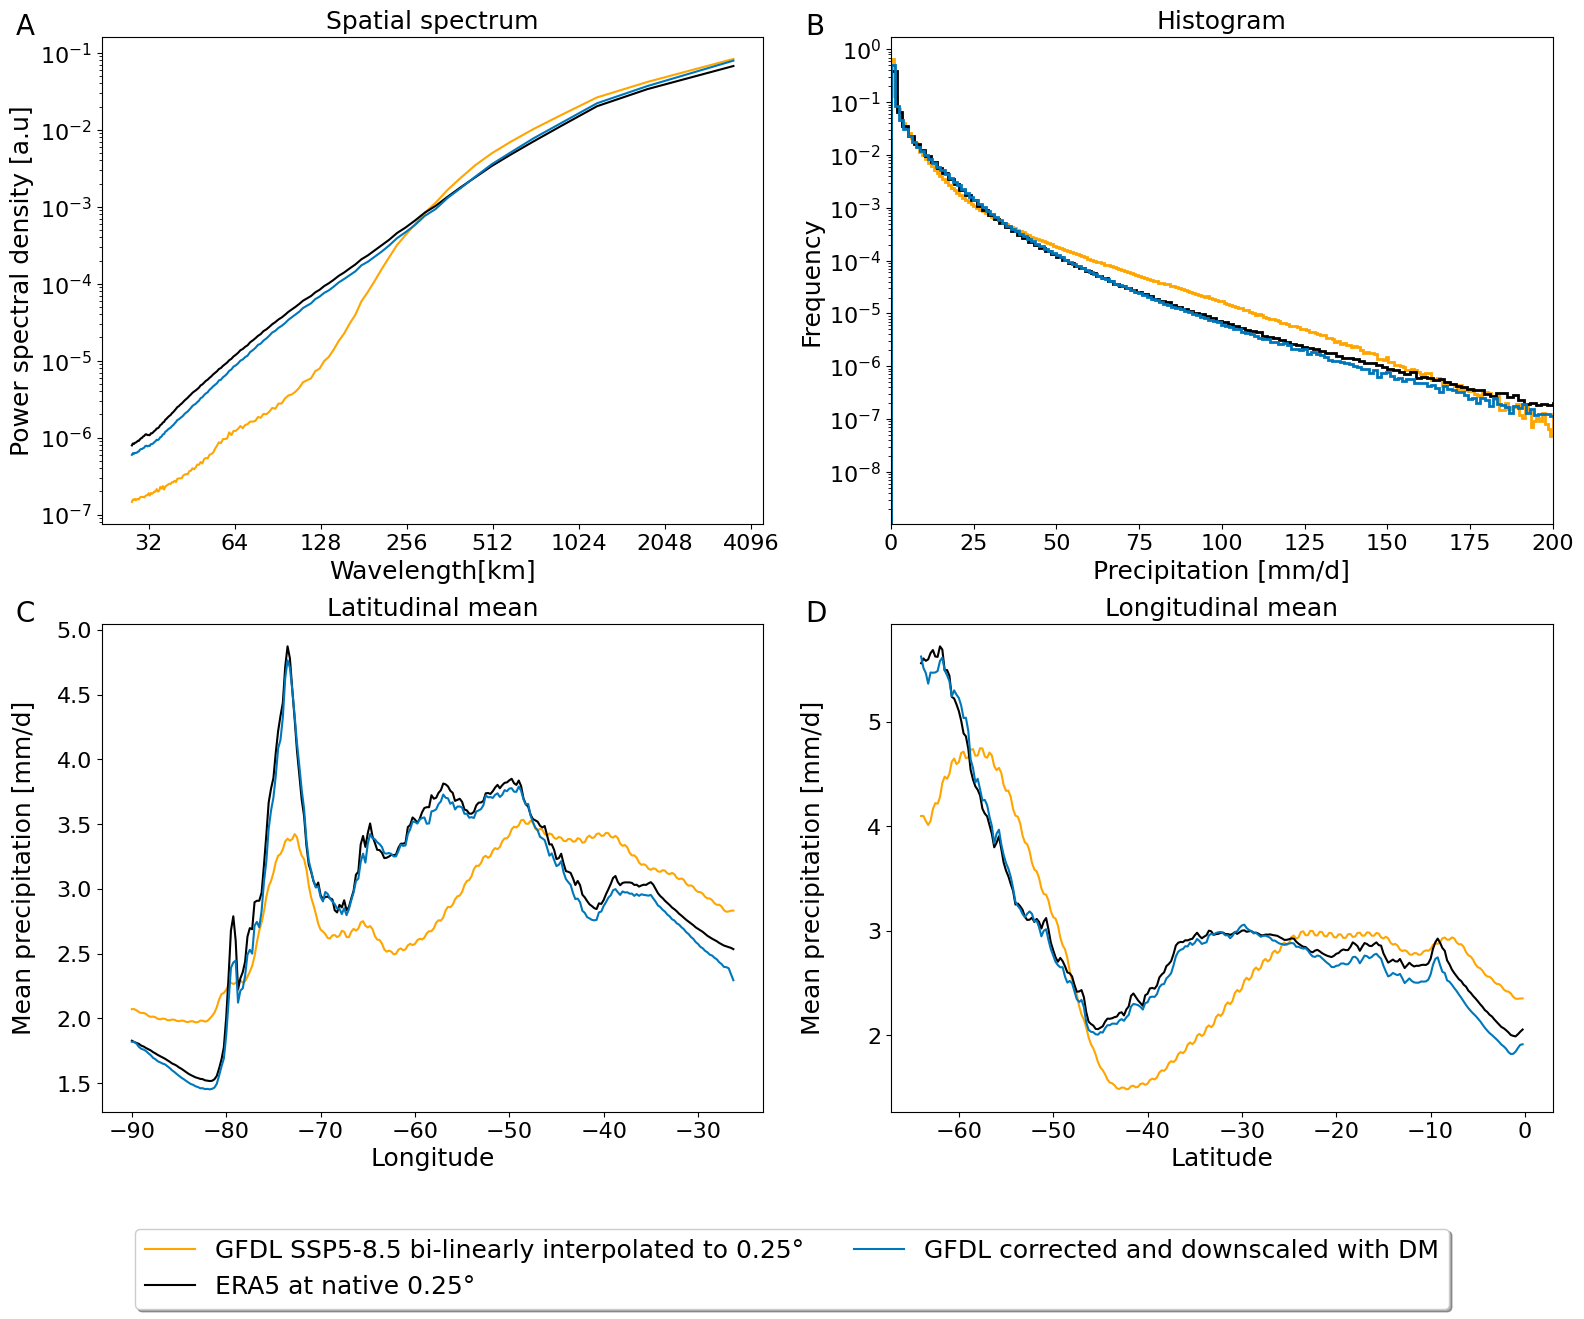

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

ssd = SpatialSpectralDensity_diff_3_paper( gfdl_ssp585.numpy()
                                      ,era5_hr.numpy()
                                      ,dm_sr_ssp.numpy()
                                      ,new_labels=['GFDL SSP5-8.5 bi-linearly interpolated to 0.25°',
                                                   'ERA5 at native 0.25°',
                                                   "GFDL corrected and downscaled with DM",]
                                      ,y_ax_name='Power spectral density [a.u]',x_ax_name=r'Wavelength[km]',
                                       title="Spatial spectrum" )
ssd.run(num_times=None)

ssd.plot_psd(model_resolution=0.25, model_resolution_2=0.25, do_savefig=False, axis=axs[0, 0])
axs[0, 0].text(-0.13, 1.05, 'A', transform=axs[0, 0].transAxes, fontsize=20, fontweight='light', va='top')

histograms_3_paper(  gfdl_ssp585.numpy()
                      ,era5_hr.numpy()
                      ,dm_sr_ssp.numpy()
                      ,label_name=['GFDL SSP5-8.5 bi-linearly interpolated to 0.25°',
                                   'ERA5 at native 0.25°',
                                   "GFDL corrected and downscaled with DM",]
                     ,xlim_end=200, bins=300, y_ax_name="Frequency", x_ax_name="Precipitation [mm/d]"
                     ,title_name="Histogram"
                     ,do_savefig=False, ax=axs[0, 1])
axs[0, 1].text(-0.13, 1.05, 'B', transform=axs[0, 1].transAxes, fontsize=20, fontweight='light', va='top')

latitudinal_mean_3_paper( gfdl_ssp585.numpy()
                          ,era5_hr.numpy()
                          ,dm_sr_ssp.numpy()
                          ,label_name=['GFDL SSP5-8.5 bi-linearly interpolated to 0.25°',
                                      'ERA5 at native 0.25°',
                                      "GFDL corrected and downscaled with DM"]
                          ,y_ax_name="Mean precipitation [mm/d]", x_ax_name="Longitude"
                         ,title_name="Latitudinal mean"
                         ,do_savefig=False, ax=axs[1, 0])
axs[1, 0].text(-0.13, 1.05, 'C', transform=axs[1, 0].transAxes, fontsize=20, fontweight='light', va='top')

longitudinal_mean_3_paper( gfdl_ssp585.numpy()
                          ,era5_hr.numpy()
                          ,dm_sr_ssp.numpy()
                          ,label_name=['GFDL SSP5-8.5 bi-linearly interpolated to 0.25°',
                                      'ERA5 at native 0.25°',
                                      "GFDL corrected and downscaled with DM"]
                          ,y_ax_name="Mean precipitation [mm/d]", x_ax_name="Latitude"
                         ,title_name="Longitudinal mean"
                         ,do_savefig=False, ax=axs[1, 1])
axs[1, 1].text(-0.13, 1.05, 'D', transform=axs[1, 1].transAxes, fontsize=20, fontweight='light', va='top')

# Set label padding only for subplots C and D (second row)
#for ax in axs[1, :]:  
axs[1,0].yaxis.labelpad = 15  
axs[1,1].yaxis.labelpad = 30 

#axs[1, 1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0)
           ,fancybox=True, shadow=True, ncol=2, fontsize=18)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.subplots_adjust(bottom=0.15)

#plt.savefig('figures_paper/ssp585.pdf', dpi=300)
plt.show()